In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
train
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import datetime
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df1=pd.read_excel("D:\Aysha\gold data.xlsx",header=10,names=['Date','Rate'])

In [3]:
df1

,Date,Rate
0,10/31/1979,3204.0
1,11/30/1979,3183.5
2,12/31/1979,3731.8
3,1/31/1980,5358.0
4,2/29/1980,5286.7
...,...,...
462,4/30/2018,87713.1
463,5/31/2018,88017.0
464,6/29/2018,86888.1
465,7/31/2018,85122.9


In [4]:
Train = df1.head(326)
Test = df1[326:]

In [5]:
Train

,Date,Rate
0,10/31/1979,3204.0
1,11/30/1979,3183.5
2,12/31/1979,3731.8
3,1/31/1980,5358.0
4,2/29/1980,5286.7
...,...,...
321,7/31/2006,29447.3
322,8/31/2006,29436.7
323,9/29/2006,27583.2
324,10/31/2006,26628.0


In [6]:
Test

,Date,Rate
326,12/29/2006,28116.5
327,1/31/2007,27961.2
328,2/28/2007,29348.2
329,3/30/2007,28785.0
330,4/30/2007,28611.5
...,...,...
462,4/30/2018,87713.1
463,5/31/2018,88017.0
464,6/29/2018,86888.1
465,7/31/2018,85122.9


In [7]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [9]:
df1['Date'] = pd.to_datetime(df1['Date'],errors='coerce')

In [11]:
df1["month"] = df1.Date.dt.strftime("%b")
df1["year"] = df1.Date.dt.strftime("%Y")

In [12]:
df1

,Date,Rate,month,year
0,1979-10-31,3204.0,Oct,1979
1,1979-11-30,3183.5,Nov,1979
2,1979-12-31,3731.8,Dec,1979
3,1980-01-31,5358.0,Jan,1980
4,1980-02-29,5286.7,Feb,1980
...,...,...,...,...
462,2018-04-30,87713.1,Apr,2018
463,2018-05-31,88017.0,May,2018
464,2018-06-29,86888.1,Jun,2018
465,2018-07-31,85122.9,Jul,2018


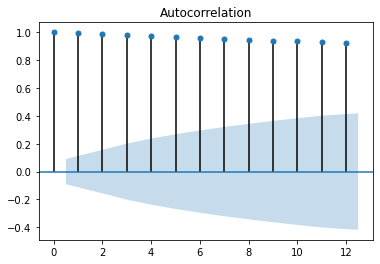

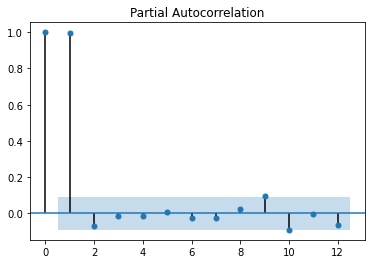

In [13]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(df1.Rate,lags=12)
tsa_plots.plot_pacf(df1.Rate,lags=12)
plt.show()


# SIMPLE EXPONENTIAL METHOD

In [14]:
ses_model = SimpleExpSmoothing(Train['Rate']).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Rate) 

53.92645043317587

# HOLT METHOD

In [15]:
# Holt method 
hw_model = Holt(Train["Rate"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Rate)

37.63164686498377

# Holts winter exponential smoothing with additive seasonality and additive trend

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

In [17]:
hwe_model_add_add = ExponentialSmoothing(Train["Rate"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Rate) 

26.718280096277326

# Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [18]:
#Forecasting for next 10 time periods
hw_model.forecast(30)

326    28067.901770
327    28229.298705
328    28390.695640
329    28552.092576
330    28713.489511
331    28874.886446
332    29036.283381
333    29197.680316
334    29359.077251
335    29520.474186
336    29681.871121
337    29843.268056
338    30004.664991
339    30166.061927
340    30327.458862
341    30488.855797
342    30650.252732
343    30811.649667
344    30973.046602
345    31134.443537
346    31295.840472
347    31457.237407
348    31618.634343
349    31780.031278
350    31941.428213
351    32102.825148
352    32264.222083
353    32425.619018
354    32587.015953
355    32748.412888
dtype: float64

# ARIMA Hyperparameters

In [19]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# Grid search for p,d,q values

In [20]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# Combine train and test data and build final model

In [31]:
# fit model
df = read_csv("D:\Aysha\gold data.csv", header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [32]:
model = ARIMA(X, order=(3,1,0))
model_fit = model.fit()

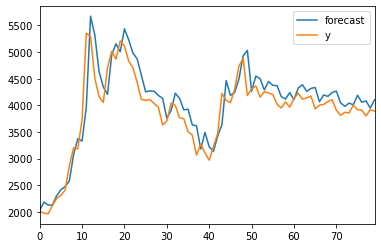

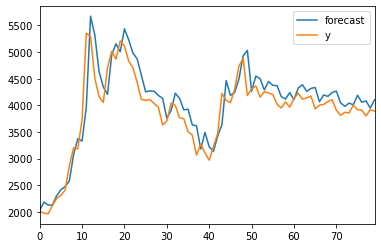

In [33]:
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,80)

In [34]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

2241.6390810321864